In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

/home/mzl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2. Data preparation（数据预处理）
### 2.1 Load data

In [3]:
# Load the data
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

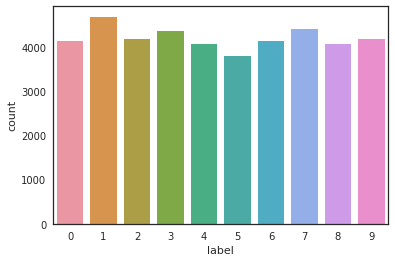

In [4]:
Y_train = train["label"]

# Drop 'label' column
#drop函数默认删除行，列需要加 axis = 1
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

#绘条形图
g = sns.countplot(Y_train)

Y_train.value_counts()

### 2.2 Check for null and missing values

In [10]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 2.4 Normalization(标准化)

In [12]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

### 2.3 Reshape

In [13]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

### 2.5 Label encoding

In [14]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

### 2.6 Split training and valdiation set(划分训练集和测试集)

In [16]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

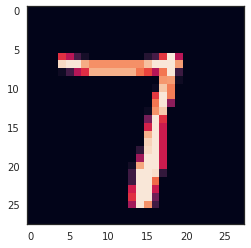

In [21]:
# Some examples
g = plt.imshow(X_train[1][:,:,0])

## 3. CNN
### 3.1 Define the model

#### 3.1.1 conv：全职共享，稀疏连接
#### 3.1.2 pool：降低计算成本，一定程度上降低过拟合
#### 3.1.3 dropout： 以一定概率失活失活神经元节点，提高泛化和减少过拟合
#### 3.1.4 relu： 激活函数，提供非线性网络
#### 3.1.4 fc: 将学到的“分布式特征表示”映射到样本标记空间的作用。

#### Set the CNN model 
#### my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

In [32]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10,activation = "softmax"))

### 3.2 Set the optimizer and annealer(设置优化器等)
#### 设计一个得分函数：损失函数和优化算法

In [33]:
# Define the optimizer
# 建议使用优化器的默认参数 （除了学习率lr）
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [34]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#### 使用 LR 衰减学习率

In [35]:
# Set a learning rate annealer
# 当标准评估已经停止时，降低学习速率
#monitor: 被监测的数据
#factor: 学习速率被降低的因数,新的学习速率 = 学习速率 * 因数
#patience: 没有进步的训练轮数，在这之后训练速率会被降低
#verbose: 整数。0：安静，1：更新信息
#min_lr: 学习速率的下边界
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [58]:
epochs = 50 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86 #86
# 128：0.9864

## 3.3 Data augmentation
#### 使用数据扩增方法避免过拟合
#### 常见的数据扩增方法有：灰度,水平翻转、垂直翻转,随机裁剪,反转,旋转,等等
#### .The improvement is important :

#### .Without data augmentation i obtained an accuracy of 98.114%
#### .With data augmentation i achieved 99.67% of accuracy

In [37]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [40]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)（随机旋转 10 度）
        zoom_range = 0.1, # Randomly zoom image （随机放大 10%）
        width_shift_range=0.1,  # randomly shift images horizontally (随机图像水平转移10%的宽度)
        height_shift_range=0.1,  # randomly shift images vertically (随机图像垂直转移10%的高度)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [52]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 24s - loss: 0.0851 - acc: 0.9746 - val_loss: 0.0371 - val_acc: 0.9902
Epoch 2/30
 - 24s - loss: 0.0737 - acc: 0.9790 - val_loss: 0.0337 - val_acc: 0.9900
Epoch 3/30
 - 24s - loss: 0.0696 - acc: 0.9800 - val_loss: 0.0255 - val_acc: 0.9914
Epoch 4/30
 - 25s - loss: 0.0636 - acc: 0.9824 - val_loss: 0.0250 - val_acc: 0.9926
Epoch 5/30
 - 26s - loss: 0.0609 - acc: 0.9832 - val_loss: 0.0339 - val_acc: 0.9900
Epoch 6/30
 - 26s - loss: 0.0610 - acc: 0.9822 - val_loss: 0.0284 - val_acc: 0.9929
Epoch 7/30
 - 26s - loss: 0.0596 - acc: 0.9833 - val_loss: 0.0234 - val_acc: 0.9940
Epoch 8/30
 - 25s - loss: 0.0618 - acc: 0.9829 - val_loss: 0.0315 - val_acc: 0.9929
Epoch 9/30
 - 26s - loss: 0.0600 - acc: 0.9828 - val_loss: 0.0232 - val_acc: 0.9931
Epoch 10/30
 - 25s - loss: 0.0586 - acc: 0.9837 - val_loss: 0.0380 - val_acc: 0.9902
Epoch 11/30
 - 25s - loss: 0.0625 - acc: 0.9827 - val_loss: 0.0365 - val_acc: 0.9898

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00050000002374

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
 - 25s - loss: 0.0318 - acc: 0.9911 - val_loss: 0.0237 - val_acc: 0.9936
Epoch 2/50
 - 26s - loss: 0.0305 - acc: 0.9907 - val_loss: 0.0204 - val_acc: 0.9955
Epoch 3/50
 - 25s - loss: 0.0303 - acc: 0.9913 - val_loss: 0.0209 - val_acc: 0.9945
Epoch 4/50
 - 25s - loss: 0.0297 - acc: 0.9911 - val_loss: 0.0223 - val_acc: 0.9957
Epoch 5/50
 - 25s - loss: 0.0331 - acc: 0.9910 - val_loss: 0.0223 - val_acc: 0.9943
Epoch 6/50
 - 25s - loss: 0.0316 - acc: 0.9909 - val_loss: 0.0248 - val_acc: 0.9929
Epoch 7/50
 - 27s - loss: 0.0298 - acc: 0.9915 - val_loss: 0.0228 - val_acc: 0.9957
Epoch 8/50
 - 27s - loss: 0.0307 - acc: 0.9912 - val_loss: 0.0207 - val_acc: 0.9948

Epoch 00008: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 9/50
 - 26s - loss: 0.0290 - acc: 0.9913 - val_loss: 0.0220 - val_acc: 0.9948
Epoch 10/50
 - 28s - loss: 0.0283 - acc: 0.9919 - val_loss: 0.0232 - val_acc: 0.9945
Epoch 11/50
 - 25s - loss: 0.0286 - acc: 0.9920 - val_loss: 0.0208 - val_acc: 0

## 4. Evaluate the model
### 4.1 Training and validation curves

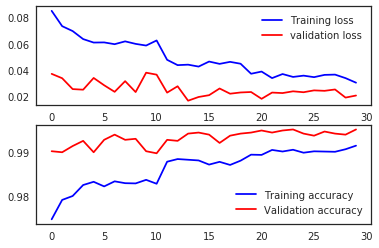

In [53]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 4.2 Confusion matrix
#### Confusion matrix can be very helpfull to see your model drawbacks

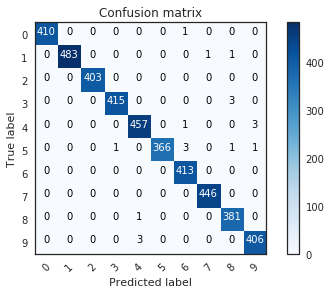

In [54]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

#### 可视化错误分类
#### Let's investigate for errors.

#### I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results

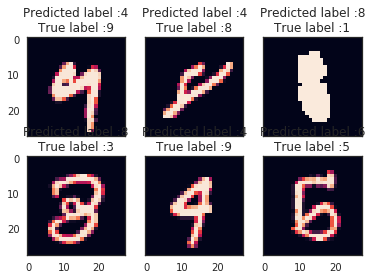

In [55]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [56]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [57]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)